In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1215

nband = 165

nv = 200

dv = 0.005

tsfc =300

ng =7

nref =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

ng_refs = (/ 7 /) 

data wgt
     &     /0.5 , 0.5 , 0.5 , 0.5,
     &     0.5 , 0.5 , 0.9/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /2 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.8/

klin =0

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

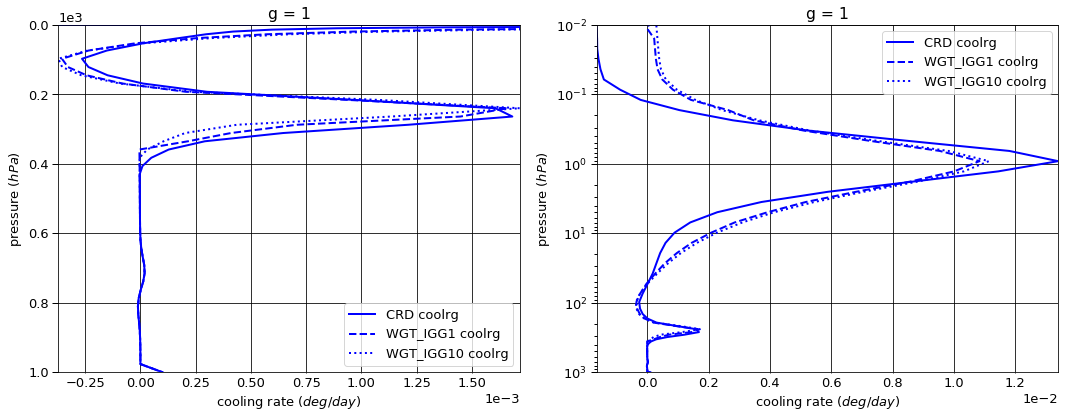

# Figure: cooling rate g-group 2

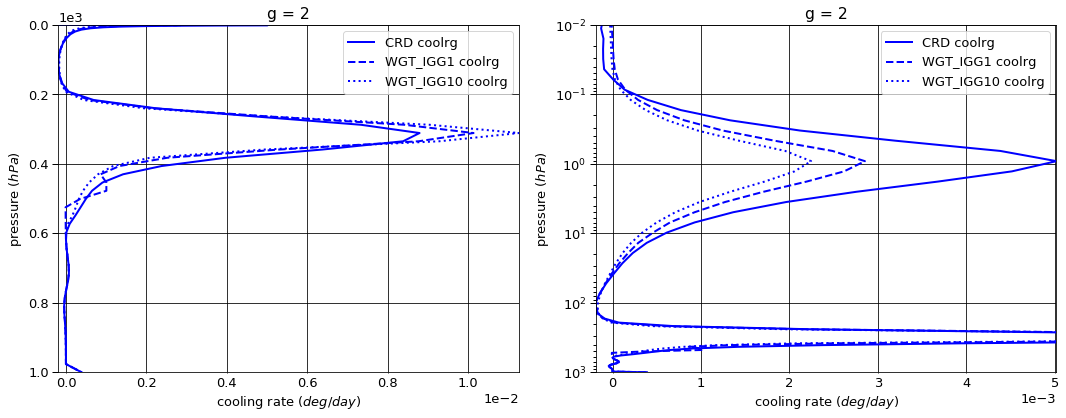

# Figure: cooling rate g-group 3

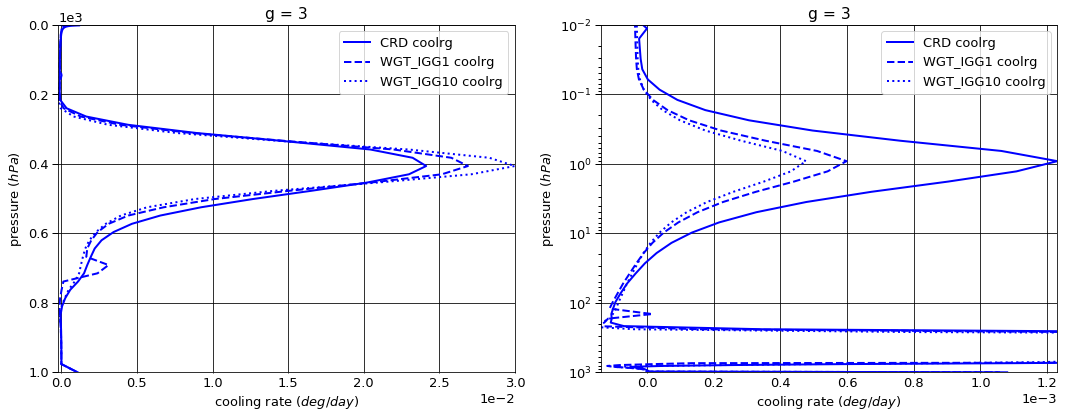

# Figure: cooling rate g-group 4

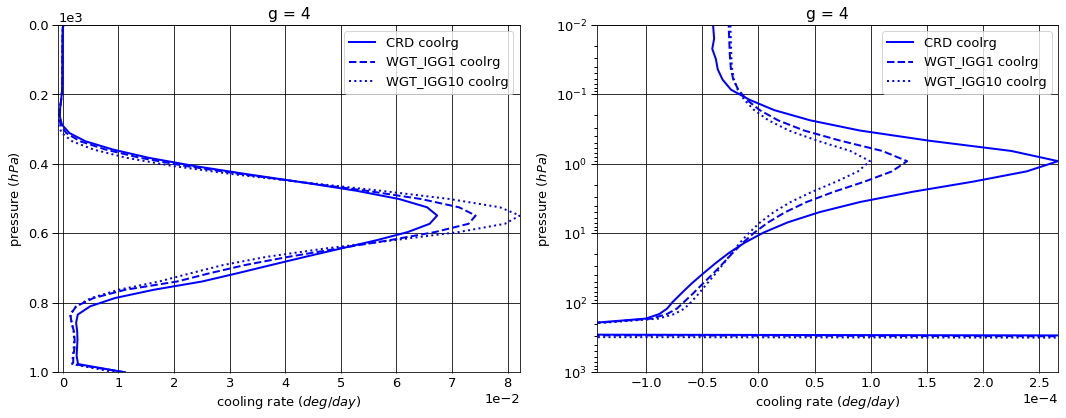

# Figure: cooling rate g-group 5

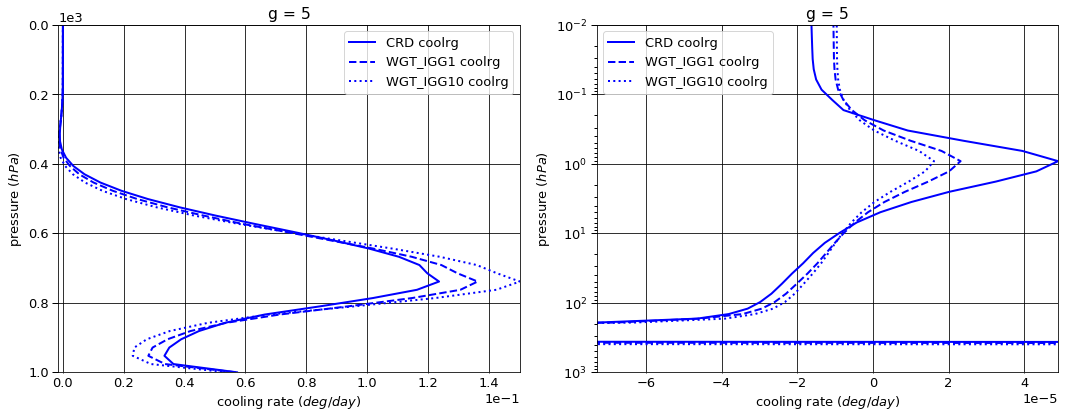

# Figure: cooling rate g-group 6

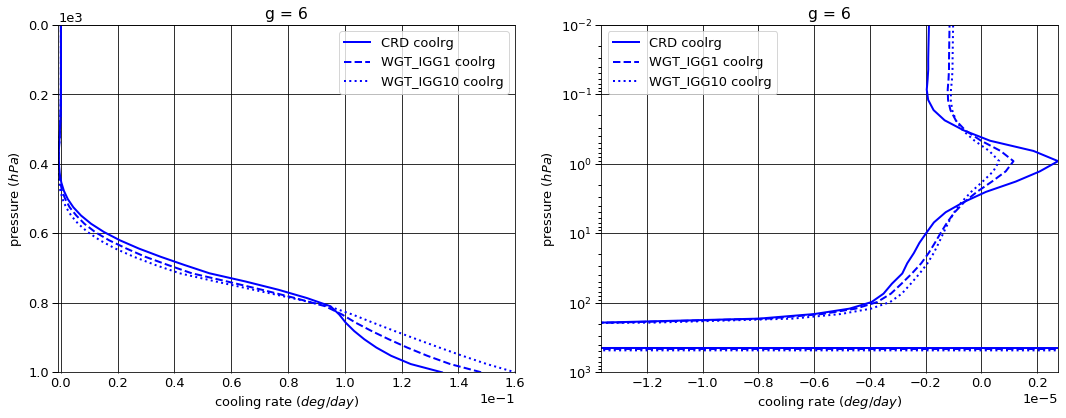

# Figure: cooling rate g-group 7

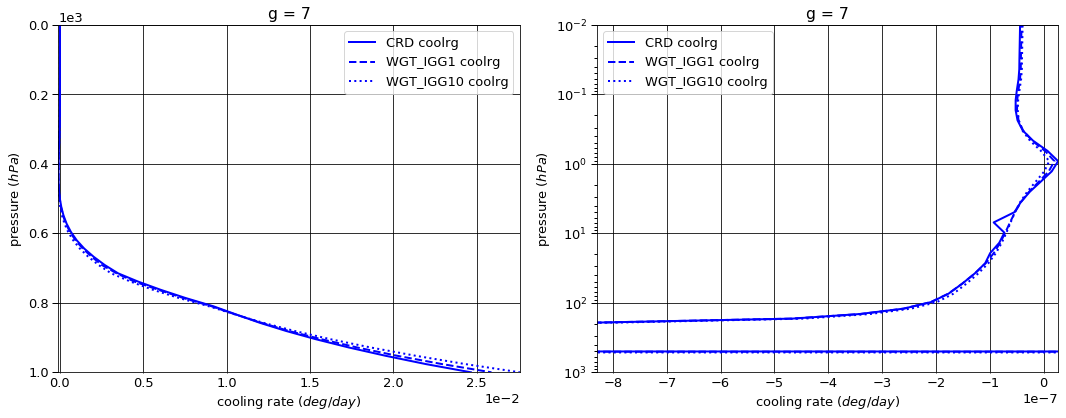

# Figure: cooling rate g-group total

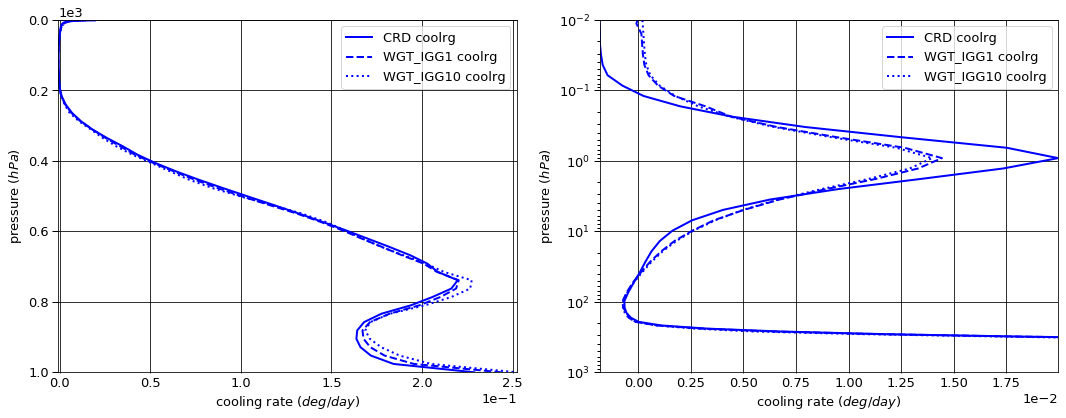

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.023598  0.000000 -0.023598
  1013.0   76    -0.193203  0.192919 -0.000284
2 0.0      1     -0.141302  0.000000 -0.141302
  1013.0   76    -0.757438  0.756339 -0.001099
3 0.0      1     -0.585667  0.000000 -0.585667
  1013.0   76    -2.074900  2.071863 -0.003037
4 0.0      1     -2.300019  0.000000 -2.300019
  1013.0   76    -5.405170  5.374504 -0.030666
5 0.0      1     -4.868036  0.000000 -4.868036
  1013.0   76    -7.997770  7.701564 -0.296206
6 0.0      1     -6.706825  0.000000 -6.706825
  1013.0   76    -8.069089  5.397121 -2.671968
7 0.0      1     -2.347394  0.000000 -2.347394
  1013.0   76    -2.465176  0.607853 -1.857323


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.021100  0.000000 -0.021100
  1013.0   76    -0.193203  0.192919 -0.000284
2 0.0      1     -0.135701  0.000000 -0.135701
  1013.0   76    -0.757438  0.756339 -0.001099
3 0.0      1     -0.572806  0.000000 -0.572806
  1013.0   76    -2.074900  2.071913 -0.002987
4 0.0      1     -2.273849  0.000000 -2.273849
  1013.0   76    -5.405170  5.375495 -0.029674
5 0.0      1     -4.879863  0.000000 -4.879863
  1013.0   76    -7.997770  7.766723 -0.231047
6 0.0      1     -6.778202  0.000000 -6.778202
  1013.0   76    -8.069089  5.370662 -2.698427
7 0.0      1     -2.348303  0.000000 -2.348303
  1013.0   76    -2.465176  0.614393 -1.850783


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019838  0.000000 -0.019838
  1013.0   76    -0.193203  0.192919 -0.000284
2 0.0      1     -0.136034  0.000000 -0.136034
  1013.0   76    -0.757438  0.756339 -0.001099
3 0.0      1     -0.572991  0.000000 -0.572991
  1013.0   76    -2.074900  2.071913 -0.002987
4 0.0      1     -2.276139  0.000000 -2.276139
  1013.0   76    -5.405170  5.380845 -0.024325
5 0.0      1     -4.897480  0.000000 -4.897480
  1013.0   76    -7.997770  7.787082 -0.210689
6 0.0      1     -6.827649  0.000000 -6.827649
  1013.0   76    -8.069089  5.431266 -2.637823
7 0.0      1     -2.350606  0.000000 -2.350606
  1013.0   76    -2.465176  0.622204 -1.842972


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      2.498594e-03  0.000000  0.002499
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      5.601230e-03  0.000000  0.005601
  1013.0   76     0.000000e+00  0.000000  0.000000
3 0.0      1      1.286161e-02  0.000000  0.012862
  1013.0   76     0.000000e+00  0.000050  0.000050
4 0.0      1      2.616980e-02  0.000000  0.026170
  1013.0   76     0.000000e+00  0.000992  0.000992
5 0.0      1     -1.182650e-02  0.000000 -0.011826
  1013.0   76    -8.881784e-16  0.065160  0.065159
6 0.0      1     -7.137680e-02  0.000000 -0.071377
  1013.0   76     0.000000e+00 -0.026459 -0.026459
7 0.0      1     -9.087000e-04  0.000000 -0.000909
  1013.0   76     0.000000e+00  0.006540  0.006540


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.760115e-03  0.000000  0.003760
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      5.267420e-03  0.000000  0.005267
  1013.0   76     0.000000e+00  0.000000  0.000000
3 0.0      1      1.267619e-02  0.000000  0.012676
  1013.0   76     0.000000e+00  0.000050  0.000050
4 0.0      1      2.388040e-02  0.000000  0.023880
  1013.0   76     0.000000e+00  0.006341  0.006341
5 0.0      1     -2.944390e-02  0.000000 -0.029444
  1013.0   76    -8.881784e-16  0.085518  0.085518
6 0.0      1     -1.208239e-01  0.000000 -0.120824
  1013.0   76     0.000000e+00  0.034144  0.034144
7 0.0      1     -3.211700e-03  0.000000 -0.003212
  1013.0   76     0.000000e+00  0.014351  0.014351

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.906646e-03
  1001.112500 75     1.005905e-04
2 0.000312    1     -1.917490e-04
  1001.112500 75     3.894199e-04
3 0.000312    1     -1.020973e-04
  1001.112500 75     1.080242e-03
4 0.000312    1     -4.508684e-05
  1001.112500 75     1.112796e-02
5 0.000312    1     -1.671568e-05
  1001.112500 75     5.726353e-02
6 0.000312    1     -1.797368e-06
  1001.112500 75     1.341871e-01
7 0.000312    1     -4.098983e-08
  1001.112500 75     2.466014e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.677372e-05
  1001.112500 75     1.005905e-04
2 0.000312    1     -4.726902e-05
  1001.112500 75     3.894199e-04
3 0.000312    1     -4.179752e-05
  1001.112500 75     1.058820e-03
4 0.000312    1     -2.867550e-05
  1001.112500 75     1.129960e-02
5 0.000312    1     -1.061461e-05
  1001.112500 75     5.678308e-02
6 0.000312    1     -1.088935e-06
  1001.112500 75     1.480571e-01
7 0.000312    1     -3.846811e-08
  1001.112500 75     2.589437e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.154477e-04
  1001.112500 75     1.005905e-04
2 0.000312    1     -5.621323e-05
  1001.112500 75     3.894199e-04
3 0.000312    1     -3.506605e-05
  1001.112500 75     1.058820e-03
4 0.000312    1     -2.655021e-05
  1001.112500 75     9.405073e-03
5 0.000312    1     -9.647013e-06
  1001.112500 75     5.381673e-02
6 0.000312    1     -9.622973e-07
  1001.112500 75     1.599589e-01
7 0.000312    1     -3.651079e-08
  1001.112500 75     2.759682e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.923420e-03
  1001.112500 75     1.355253e-20
2 0.000312    1      1.444799e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.029975e-05
  1001.112500 75    -2.142180e-05
4 0.000312    1      1.641134e-05
  1001.112500 75     1.716340e-04
5 0.000312    1      6.101077e-06
  1001.112500 75    -4.804500e-04
6 0.000312    1      7.084329e-07
  1001.112500 75     1.386995e-02
7 0.000312    1      2.521712e-09
  1001.112500 75     1.234233e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.022094e-03
  1001.112500 75     1.355253e-20
2 0.000312    1      1.355357e-04
  1001.112500 75     0.000000e+00
3 0.000312    1      6.703122e-05
  1001.112500 75    -2.142180e-05
4 0.000312    1      1.853662e-05
  1001.112500 75    -1.722891e-03
5 0.000312    1      7.068670e-06
  1001.112500 75    -3.446800e-03
6 0.000312    1      8.350709e-07
  1001.112500 75     2.577177e-02
7 0.000312    1      4.479041e-09
  1001.112500 75     2.936684e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.972842,0.000000,-16.972842
1013.0,76,-26.962746,22.102163,-4.860583



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.009823,0.000000,-17.009823
1013.0,76,-26.962746,22.148446,-4.814300



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-17.080738,0.000000,-17.080738
1013.0,76,-26.962746,22.242568,-4.720178



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.036981,0.000000,-0.036981
1013.0,76,0.000000,0.046283,0.046282



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.107895,0.000000,-0.107895
1013.0,76,0.000000,0.140405,0.140405


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.002264
1001.112500,75,0.228809



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000113
1001.112500,75,0.243583



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.252326



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002151
1001.112500,75,0.014774



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.002251
1001.112500,75,0.023517


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008455,0.006707
2,0.031727,0.026763
3,0.084848,0.074071
4,0.218515,0.193788
5,0.300788,0.294611
6,0.276970,0.307518
7,0.078697,0.096542


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.686315e-20
2,2.515606e-21
3,3.752724e-22
4,5.598228e-23
5,8.351308e-24
6,1.245829e-24
7,1.858499e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.686315e-20,NaN,0.008455,0.006707,0.008455,0.006707,600.0
2,2.515606e-21,0.149178,0.031727,0.026763,0.040182,0.033469,600.0
3,3.752724e-22,0.149178,0.084848,0.074071,0.125030,0.107541,600.0
4,5.598228e-23,0.149178,0.218515,0.193788,0.343545,0.301328,600.0
5,8.351308e-24,0.149178,0.300788,0.294611,0.644333,0.595939,600.0
6,1.245829e-24,0.149178,0.276970,0.307518,0.921303,0.903458,600.0
7,1.858499e-25,0.149178,0.078697,0.096542,1.000000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     2.929825e-20  1.488331e-21  19.685313  1.065115e-06
      2 0.000312     1.833133e-21  9.623192e-23  19.049115  6.674968e-08
      3 0.000312     1.449484e-22  1.082376e-23  13.391682  5.389206e-09
      4 0.000312     2.109715e-23  1.638229e-24  12.878018  7.865693e-10
      5 0.000312     3.205445e-24  2.085098e-25  15.373110  1.181116e-10
      6 0.000312     2.068785e-25  2.227320e-26   9.288224  7.927896e-12
      7 0.000312     1.203712e-26  2.397317e-27   5.021080  7.661887e-13
2     1 0.000750     2.945667e-20  1.490732e-21  19.759870  4.312550e-07
      2 0.000750     1.843399e-21  9.650937e-23  19.100730  2.703281e-08
      3 0.000750     1.457679e-22  1.084764e-23  13.437751  2.182452e-09
      4 0.000750     2.114596e-23  1.642315e-24  12.875706  3.175568e-10
      5 0.000750     3.216542e-24  2.091908e-25  15.376115  4.773792e-11
      6 0.000750     2.081515e-25  2.236304e-26   9.307835  3.212242e-12
      7 0.000750     1.211908e-26  2.406456e-27   5.036069  3.106919e-13
3     1 0.001052     2.977956e-20  1.495369e-21  19.914517  6.111865e-07
      2 0.001052     1.864369e-21  9.705109e-23  19.210185  3.833082e-08
      3 0.001052     1.474445e-22  1.089416e-23  13.534267  3.094314e-09
      4 0.001052     2.124592e-23  1.650330e-24  12.873738  4.474472e-10
      5 0.001052     3.239172e-24  2.105304e-25  15.385771  6.741540e-11
      6 0.001052     2.107544e-25  2.254231e-26   9.349279  4.559172e-12
      7 0.001052     1.228688e-26  2.424676e-27   5.067432  4.416836e-13
4     1 0.001476     3.010969e-20  1.500114e-21  20.071605  8.666095e-07
      2 0.001476     1.885858e-21  9.760317e-23  19.321689  5.437827e-08
      3 0.001476     1.491661e-22  1.094179e-23  13.632697  4.389495e-09
      4 0.001476     2.134874e-23  1.658547e-24  12.871954  6.307643e-10
      5 0.001476     3.262319e-24  2.119048e-25  15.395211  9.524879e-11
      6 0.001476     2.134264e-25  2.272648e-26   9.391089  6.474331e-12
      7 0.001476     1.246013e-26  2.443506e-27   5.099285  6.282872e-13
5     1 0.002070     3.044266e-20  1.504924e-21  20.228706  1.228484e-06
      2 0.002070     1.907581e-21  9.815965e-23  19.433451  7.712695e-08
      3 0.002070     1.509102e-22  1.099007e-23  13.731502  6.225568e-09
      4 0.002070     2.145310e-23  1.666882e-24  12.870197  8.890352e-10
      5 0.002070     3.285677e-24  2.133000e-25  15.404016  1.345465e-10
      6 0.002070     2.161326e-25  2.291347e-26   9.432555  9.192064e-12
      7 0.002070     1.263665e-26  2.462750e-27   5.131114  8.935934e-13
6     1 0.002904     3.077839e-20  1.509831e-21  20.385319  1.741615e-06
      2 0.002904     1.929533e-21  9.872281e-23  19.544952  1.094033e-07
      3 0.002904     1.526763e-22  1.103923e-23  13.830344  8.830754e-09
      4 0.002904     2.155900e-23  1.675368e-24  12.868214  1.253253e-09
      5 0.002904     3.309243e-24  2.147211e-25  15.411815  1.900813e-10
      6 0.002904     2.188726e-25  2.310373e-26   9.473476  1.305211e-11
      7 0.002904     1.281651e-26  2.482473e-27   5.162798  1.271152e-12
7     1 0.004074     3.111687e-20  1.514880e-21  20.540812  2.469084e-06
      2 0.004074     1.951713e-21  9.929620e-23  19.655462  1.551897e-07
      3 0.004074     1.544645e-22  1.108961e-23  13.928753  1.252666e-08
      4 0.004074     2.166646e-23  1.684056e-24  12.865642  1.766818e-09
      5 0.004074     3.333018e-24  2.161762e-25  15.418062  2.685501e-10
      6 0.004074     2.216467e-25  2.329796e-26   9.513567  1.853375e-11
      7 0.004074     1.299982e-26  2.502767e-27   5.194178  1.808412e-12
8     1 0.005714     3.145832e-20  1.520138e-21  20.694388  3.500132e-06
      2 0.005714     1.974135e-21  9.988529e-23  19.764024  2.201239e-07
      3 0.005714     1.562759e-22  1.114177e-23  14.026133  1.776869e-08
      4 0.005714     2.177558e-23  1.693020e-24  12.861974  2.490814e-09
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
